In [0]:
# TensorFlow と tf.keras のインポート
import tensorflow as tf
from tensorflow import keras

# Oputunaのインストール

OptunaとはPFNが世に送り出した最適化枝刈りライブラリです。

In [0]:
!pip install optuna

## データのインポート（501と同じ）

In [0]:
import cv2
import numpy as np
import os
from glob import glob

Path = glob("/content/drive/My Drive/Colab Notebooks/face/*/")

# 空のリストを準備
data = []
label = [] 
class_num = 0

# 画像サイズ
image_size = 28

def append_data(directory, class_num):
    # 例：['KA.AN2.40.jpg', 'KA.AN3.41.jpg',,,,,'KL.AN2.168.jpg', 'KL.AN3.169.jpg']
    files = os.listdir(directory)  # ディレクトリの中をファイルを全てリストにする
    for image in files:
        if image.endswith(".jpg"): # jpg画像だけを抽出
            image = cv2.imread(directory + image) # 画像を準備
            image = cv2.resize(image, (image_size, image_size)) # リサイズ
            image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # グレースケール
            image_gs = image_gs.flatten() # リストを平坦化     
            data.append(image_gs)  # 学習用データに代入
            label.append(class_num)  # 学習用データのラベルに代入
                
for fil in Path:
    append_data(fil, class_num)
    class_num += 1

print(label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


## CNNに適用する型に変更（501と同じ）

In [0]:
# データ型を変更
data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

# 学習データとテストデータに分割
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data,label, 
                                                                  random_state = 0, 
                                                                  stratify = label, 
                                                                  test_size = 0.2)

# 学習データのリストを変形  #.reshape(データの数, 縦のサイズ, 横のサイズ, 次元)
train_data = train_data.reshape((len(train_data)),image_size,image_size,1)
test_data = test_data.reshape((len(test_data)),image_size,image_size,1)

# 学習データを正規化
train_data /= 255 # to 0-1
test_data /= 255 # to 0-1

# ラベルデータをone-hot 変換
from keras.utils.np_utils import to_categorical
train_label = to_categorical(train_label, num_classes=5)
test_label = to_categorical(test_label, num_classes=5)

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape) 

test_label

(121, 28, 28, 1) (121, 5) (31, 28, 28, 1) (31, 5)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## ニューラルネットワークのモデルを作成、学習する関数を作ろう

In [0]:
import optuna
import keras.backend as K
from tensorflow.keras import models,layers
from keras import optimizers

mymodels = []
histories = []

# モデルの作成
def create_model(num_layer, activation):
    model = models.Sequential()
    # コンボリューションの部分は今回固定することにする
    model.add(layers.Conv2D(20, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
    model.add(layers.Flatten())
    for i in range(num_layer):
        model.add(layers.Dense(500, activation=activation)) # 隠れ層
        model.add(layers.BatchNormalization()) #model.add(layers.Dropout(rate=0.5)) # ドロップアウト
    model.add(layers.Dense(5, activation='softmax')) # 出力層
    return model

def objective(trial):
    K.clear_session()

    #「層の数」（1-3層の中から最適なものを選ばせる）
    num_layer = trial.suggest_int("num_layer", 1, 3)

    #「活性化関数」（relu、sigmoidの中から最適なものを選ばせる）
    activation = trial.suggest_categorical("activation", ["relu", "sigmoid"])

    #「オプティマイザ」（sgd,adam,rmspropの中から最適なものを選ばせる）
    optimizer = trial.suggest_categorical("optimizer", ["sgd", "adam", "rmsprop"])

    # モデルの生成
    model = create_model(num_layer, activation)

    # コンパイル
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # 学習
    history = model.fit(train_data,
                        train_label, 
                        batch_size=batchsize,
                        epochs=epoch, 
                        verbose=2,
                        validation_data=(test_data, test_label))

    mymodels.append(model) # あとで、モデルを保存するために学習済みモデルをリスト化
    histories.append(history)

    # この戻り値が最小になるパラメータの組み合わせを探索
    return 1 - history.history["val_accuracy"][-1]

## 探索させよう

In [0]:
epoch = 100
batchsize = 20

study = optuna.create_study()
study.optimize(objective, n_trials=10)

Epoch 1/100
7/7 - 0s - loss: 2.8864 - accuracy: 0.2479 - val_loss: 2.3231 - val_accuracy: 0.1935
Epoch 2/100
7/7 - 0s - loss: 1.9910 - accuracy: 0.4380 - val_loss: 1.5765 - val_accuracy: 0.1935
Epoch 3/100
7/7 - 0s - loss: 1.2830 - accuracy: 0.5785 - val_loss: 1.6653 - val_accuracy: 0.2581
Epoch 4/100
7/7 - 0s - loss: 0.8397 - accuracy: 0.7521 - val_loss: 2.2877 - val_accuracy: 0.1935
Epoch 5/100
7/7 - 0s - loss: 0.8763 - accuracy: 0.7190 - val_loss: 4.3645 - val_accuracy: 0.1935
Epoch 6/100
7/7 - 0s - loss: 0.8303 - accuracy: 0.8347 - val_loss: 4.5904 - val_accuracy: 0.1935
Epoch 7/100
7/7 - 0s - loss: 0.5418 - accuracy: 0.8926 - val_loss: 6.3579 - val_accuracy: 0.1935
Epoch 8/100
7/7 - 0s - loss: 0.5601 - accuracy: 0.8926 - val_loss: 5.6842 - val_accuracy: 0.1935
Epoch 9/100
7/7 - 0s - loss: 0.4381 - accuracy: 0.9421 - val_loss: 6.0631 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.6858 - accuracy: 0.8512 - val_loss: 7.8229 - val_accuracy: 0.1935
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:45:03,205] Finished trial#0 with value: 0.19354838132858276 with parameters: {'num_layer': 3, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial#0 with value: 0.19354838132858276.


Epoch 1/100
7/7 - 0s - loss: 2.8229 - accuracy: 0.2975 - val_loss: 1.6188 - val_accuracy: 0.1935
Epoch 2/100
7/7 - 0s - loss: 1.9970 - accuracy: 0.4545 - val_loss: 1.6061 - val_accuracy: 0.2581
Epoch 3/100
7/7 - 0s - loss: 1.1137 - accuracy: 0.6446 - val_loss: 1.6895 - val_accuracy: 0.1935
Epoch 4/100
7/7 - 0s - loss: 1.1098 - accuracy: 0.6694 - val_loss: 2.0781 - val_accuracy: 0.1935
Epoch 5/100
7/7 - 0s - loss: 0.5849 - accuracy: 0.8595 - val_loss: 2.8166 - val_accuracy: 0.1935
Epoch 6/100
7/7 - 0s - loss: 0.9246 - accuracy: 0.7686 - val_loss: 3.5125 - val_accuracy: 0.1935
Epoch 7/100
7/7 - 0s - loss: 0.7558 - accuracy: 0.8430 - val_loss: 2.3024 - val_accuracy: 0.1935
Epoch 8/100
7/7 - 0s - loss: 0.5017 - accuracy: 0.8926 - val_loss: 4.2352 - val_accuracy: 0.1935
Epoch 9/100
7/7 - 0s - loss: 0.5234 - accuracy: 0.9008 - val_loss: 5.7707 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.4756 - accuracy: 0.8843 - val_loss: 6.3574 - val_accuracy: 0.2581
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:45:15,358] Finished trial#1 with value: 0.06451612710952759 with parameters: {'num_layer': 3, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial#1 with value: 0.06451612710952759.


Epoch 1/100
7/7 - 0s - loss: 2.0892 - accuracy: 0.3802 - val_loss: 2.0117 - val_accuracy: 0.1935
Epoch 2/100
7/7 - 0s - loss: 0.8868 - accuracy: 0.7025 - val_loss: 1.9751 - val_accuracy: 0.1935
Epoch 3/100
7/7 - 0s - loss: 0.6563 - accuracy: 0.8182 - val_loss: 1.9328 - val_accuracy: 0.1935
Epoch 4/100
7/7 - 0s - loss: 0.4669 - accuracy: 0.9091 - val_loss: 1.8957 - val_accuracy: 0.1935
Epoch 5/100
7/7 - 0s - loss: 0.3021 - accuracy: 0.9752 - val_loss: 1.8601 - val_accuracy: 0.1935
Epoch 6/100
7/7 - 0s - loss: 0.3232 - accuracy: 0.9752 - val_loss: 1.8293 - val_accuracy: 0.1935
Epoch 7/100
7/7 - 0s - loss: 0.3136 - accuracy: 0.9669 - val_loss: 1.8111 - val_accuracy: 0.1935
Epoch 8/100
7/7 - 0s - loss: 0.2507 - accuracy: 0.9917 - val_loss: 1.7833 - val_accuracy: 0.1935
Epoch 9/100
7/7 - 0s - loss: 0.2825 - accuracy: 0.9835 - val_loss: 1.7602 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.2605 - accuracy: 0.9917 - val_loss: 1.7458 - val_accuracy: 0.1935
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:45:25,603] Finished trial#2 with value: 0.09677422046661377 with parameters: {'num_layer': 3, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial#1 with value: 0.06451612710952759.


Epoch 1/100
7/7 - 0s - loss: 1.9772 - accuracy: 0.3388 - val_loss: 1.5816 - val_accuracy: 0.3226
Epoch 2/100
7/7 - 0s - loss: 1.0006 - accuracy: 0.6694 - val_loss: 1.5747 - val_accuracy: 0.4516
Epoch 3/100
7/7 - 0s - loss: 0.6683 - accuracy: 0.8595 - val_loss: 1.5610 - val_accuracy: 0.2581
Epoch 4/100
7/7 - 0s - loss: 0.5292 - accuracy: 0.9174 - val_loss: 1.5567 - val_accuracy: 0.3548
Epoch 5/100
7/7 - 0s - loss: 0.3823 - accuracy: 0.9587 - val_loss: 1.5807 - val_accuracy: 0.2258
Epoch 6/100
7/7 - 0s - loss: 0.3154 - accuracy: 0.9835 - val_loss: 1.6080 - val_accuracy: 0.2258
Epoch 7/100
7/7 - 0s - loss: 0.3231 - accuracy: 0.9752 - val_loss: 1.6838 - val_accuracy: 0.1935
Epoch 8/100
7/7 - 0s - loss: 0.3169 - accuracy: 0.9669 - val_loss: 1.7453 - val_accuracy: 0.1935
Epoch 9/100
7/7 - 0s - loss: 0.2628 - accuracy: 0.9917 - val_loss: 1.8263 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.2828 - accuracy: 0.9752 - val_loss: 1.9037 - val_accuracy: 0.1935
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:45:35,127] Finished trial#3 with value: 0.03225809335708618 with parameters: {'num_layer': 2, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial#3 with value: 0.03225809335708618.


Epoch 1/100
7/7 - 0s - loss: 2.9079 - accuracy: 0.3223 - val_loss: 1.6302 - val_accuracy: 0.1935
Epoch 2/100
7/7 - 0s - loss: 1.5546 - accuracy: 0.5868 - val_loss: 1.6284 - val_accuracy: 0.1935
Epoch 3/100
7/7 - 0s - loss: 0.7835 - accuracy: 0.7521 - val_loss: 1.6060 - val_accuracy: 0.1935
Epoch 4/100
7/7 - 0s - loss: 0.5312 - accuracy: 0.8595 - val_loss: 1.5947 - val_accuracy: 0.1935
Epoch 5/100
7/7 - 0s - loss: 0.4984 - accuracy: 0.9091 - val_loss: 1.5903 - val_accuracy: 0.1935
Epoch 6/100
7/7 - 0s - loss: 0.4273 - accuracy: 0.8926 - val_loss: 1.5815 - val_accuracy: 0.1935
Epoch 7/100
7/7 - 0s - loss: 0.3199 - accuracy: 0.9669 - val_loss: 1.5730 - val_accuracy: 0.1935
Epoch 8/100
7/7 - 0s - loss: 0.3287 - accuracy: 0.9504 - val_loss: 1.5710 - val_accuracy: 0.1935
Epoch 9/100
7/7 - 0s - loss: 0.3777 - accuracy: 0.9504 - val_loss: 1.5681 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.3576 - accuracy: 0.9504 - val_loss: 1.5418 - val_accuracy: 0.1935
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:45:45,806] Finished trial#4 with value: 0.12903225421905518 with parameters: {'num_layer': 3, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial#3 with value: 0.03225809335708618.


Epoch 1/100
7/7 - 0s - loss: 2.7748 - accuracy: 0.3388 - val_loss: 2.1478 - val_accuracy: 0.1935
Epoch 2/100
7/7 - 0s - loss: 1.3923 - accuracy: 0.5868 - val_loss: 1.4787 - val_accuracy: 0.3226
Epoch 3/100
7/7 - 0s - loss: 0.8941 - accuracy: 0.7521 - val_loss: 1.6683 - val_accuracy: 0.2581
Epoch 4/100
7/7 - 0s - loss: 0.8349 - accuracy: 0.8099 - val_loss: 2.2490 - val_accuracy: 0.1935
Epoch 5/100
7/7 - 0s - loss: 0.5829 - accuracy: 0.9091 - val_loss: 2.6700 - val_accuracy: 0.1935
Epoch 6/100
7/7 - 0s - loss: 0.6826 - accuracy: 0.8678 - val_loss: 4.1259 - val_accuracy: 0.1935
Epoch 7/100
7/7 - 0s - loss: 0.5531 - accuracy: 0.8926 - val_loss: 3.6282 - val_accuracy: 0.1935
Epoch 8/100
7/7 - 0s - loss: 0.5241 - accuracy: 0.8595 - val_loss: 3.7233 - val_accuracy: 0.1935
Epoch 9/100
7/7 - 0s - loss: 0.3643 - accuracy: 0.9587 - val_loss: 3.5640 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.2660 - accuracy: 0.9835 - val_loss: 6.6812 - val_accuracy: 0.1935
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:45:56,740] Finished trial#5 with value: 0.25806450843811035 with parameters: {'num_layer': 2, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial#3 with value: 0.03225809335708618.


Epoch 1/100
7/7 - 0s - loss: 2.1838 - accuracy: 0.4050 - val_loss: 1.6742 - val_accuracy: 0.3226
Epoch 2/100
7/7 - 0s - loss: 0.8649 - accuracy: 0.6942 - val_loss: 1.6641 - val_accuracy: 0.2258
Epoch 3/100
7/7 - 0s - loss: 0.6093 - accuracy: 0.8595 - val_loss: 1.5252 - val_accuracy: 0.3226
Epoch 4/100
7/7 - 0s - loss: 0.4690 - accuracy: 0.9091 - val_loss: 1.5811 - val_accuracy: 0.3548
Epoch 5/100
7/7 - 0s - loss: 0.4047 - accuracy: 0.9669 - val_loss: 1.8324 - val_accuracy: 0.4194
Epoch 6/100
7/7 - 0s - loss: 0.3718 - accuracy: 0.9752 - val_loss: 2.1445 - val_accuracy: 0.3226
Epoch 7/100
7/7 - 0s - loss: 0.3689 - accuracy: 0.9587 - val_loss: 2.3959 - val_accuracy: 0.2258
Epoch 8/100
7/7 - 0s - loss: 0.2602 - accuracy: 0.9917 - val_loss: 2.6175 - val_accuracy: 0.1935
Epoch 9/100
7/7 - 0s - loss: 0.2668 - accuracy: 0.9917 - val_loss: 3.1012 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.2722 - accuracy: 0.9835 - val_loss: 3.5013 - val_accuracy: 0.1935
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:46:05,710] Finished trial#6 with value: 0.09677422046661377 with parameters: {'num_layer': 1, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial#3 with value: 0.03225809335708618.


Epoch 1/100
7/7 - 0s - loss: 2.0608 - accuracy: 0.3058 - val_loss: 1.5920 - val_accuracy: 0.1935
Epoch 2/100
7/7 - 0s - loss: 1.1777 - accuracy: 0.6033 - val_loss: 1.5736 - val_accuracy: 0.1935
Epoch 3/100
7/7 - 0s - loss: 0.9601 - accuracy: 0.7025 - val_loss: 1.5578 - val_accuracy: 0.4194
Epoch 4/100
7/7 - 0s - loss: 0.5771 - accuracy: 0.8347 - val_loss: 1.5681 - val_accuracy: 0.2903
Epoch 5/100
7/7 - 0s - loss: 0.5389 - accuracy: 0.8512 - val_loss: 1.6164 - val_accuracy: 0.2581
Epoch 6/100
7/7 - 0s - loss: 0.5056 - accuracy: 0.8595 - val_loss: 1.6560 - val_accuracy: 0.1935
Epoch 7/100
7/7 - 0s - loss: 0.4545 - accuracy: 0.9174 - val_loss: 1.7246 - val_accuracy: 0.1935
Epoch 8/100
7/7 - 0s - loss: 0.3752 - accuracy: 0.9752 - val_loss: 1.8582 - val_accuracy: 0.1935
Epoch 9/100
7/7 - 0s - loss: 0.2803 - accuracy: 0.9917 - val_loss: 2.0179 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.3201 - accuracy: 0.9669 - val_loss: 2.1380 - val_accuracy: 0.1935
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:46:15,832] Finished trial#7 with value: 0.09677422046661377 with parameters: {'num_layer': 3, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial#3 with value: 0.03225809335708618.


Epoch 1/100
7/7 - 0s - loss: 3.0182 - accuracy: 0.3306 - val_loss: 3.4448 - val_accuracy: 0.1935
Epoch 2/100
7/7 - 0s - loss: 1.3446 - accuracy: 0.4298 - val_loss: 3.0562 - val_accuracy: 0.1935
Epoch 3/100
7/7 - 0s - loss: 1.2355 - accuracy: 0.5620 - val_loss: 2.5138 - val_accuracy: 0.2258
Epoch 4/100
7/7 - 0s - loss: 1.1165 - accuracy: 0.5785 - val_loss: 2.2402 - val_accuracy: 0.2581
Epoch 5/100
7/7 - 0s - loss: 1.0549 - accuracy: 0.6612 - val_loss: 1.8910 - val_accuracy: 0.2258
Epoch 6/100
7/7 - 0s - loss: 0.8765 - accuracy: 0.7603 - val_loss: 1.5414 - val_accuracy: 0.3226
Epoch 7/100
7/7 - 0s - loss: 0.7975 - accuracy: 0.7769 - val_loss: 1.5504 - val_accuracy: 0.4516
Epoch 8/100
7/7 - 0s - loss: 0.6632 - accuracy: 0.8099 - val_loss: 1.4581 - val_accuracy: 0.4516
Epoch 9/100
7/7 - 0s - loss: 0.5400 - accuracy: 0.8760 - val_loss: 1.9033 - val_accuracy: 0.1935
Epoch 10/100
7/7 - 0s - loss: 0.5287 - accuracy: 0.9174 - val_loss: 1.6205 - val_accuracy: 0.2903
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:46:25,611] Finished trial#8 with value: 0.12903225421905518 with parameters: {'num_layer': 1, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial#3 with value: 0.03225809335708618.


Epoch 1/100
7/7 - 0s - loss: 2.8668 - accuracy: 0.3554 - val_loss: 1.9361 - val_accuracy: 0.1935
Epoch 2/100
7/7 - 0s - loss: 1.9251 - accuracy: 0.4545 - val_loss: 1.7975 - val_accuracy: 0.1935
Epoch 3/100
7/7 - 0s - loss: 1.3961 - accuracy: 0.5620 - val_loss: 1.7014 - val_accuracy: 0.1613
Epoch 4/100
7/7 - 0s - loss: 1.0102 - accuracy: 0.6694 - val_loss: 1.6618 - val_accuracy: 0.2258
Epoch 5/100
7/7 - 0s - loss: 0.8761 - accuracy: 0.7190 - val_loss: 1.5633 - val_accuracy: 0.3871
Epoch 6/100
7/7 - 0s - loss: 0.9746 - accuracy: 0.7521 - val_loss: 1.9565 - val_accuracy: 0.3548
Epoch 7/100
7/7 - 0s - loss: 0.6358 - accuracy: 0.8264 - val_loss: 2.3419 - val_accuracy: 0.2258
Epoch 8/100
7/7 - 0s - loss: 0.6481 - accuracy: 0.8595 - val_loss: 2.9448 - val_accuracy: 0.2258
Epoch 9/100
7/7 - 0s - loss: 0.5576 - accuracy: 0.8760 - val_loss: 2.6555 - val_accuracy: 0.2258
Epoch 10/100
7/7 - 0s - loss: 0.5650 - accuracy: 0.9256 - val_loss: 2.0656 - val_accuracy: 0.3226
Epoch 11/100
7/7 - 0s - loss:

[I 2020-04-12 12:46:37,639] Finished trial#9 with value: 0.3548387289047241 with parameters: {'num_layer': 3, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial#3 with value: 0.03225809335708618.


## 探索結果を確認しよう

In [0]:
# どんなハイパーパラメータを探索して、それぞれのhistory.history['val_accuracy']を見てみる
df = study.trials_dataframe()
df.head(10)

,number,value,datetime_start,datetime_complete,params_activation,params_num_layer,params_optimizer,state
0,0,0.193548,2020-04-12 12:44:50.731626,2020-04-12 12:45:03.204710,relu,3,rmsprop,COMPLETE
1,1,0.064516,2020-04-12 12:45:03.206391,2020-04-12 12:45:15.358361,relu,3,rmsprop,COMPLETE
2,2,0.096774,2020-04-12 12:45:15.359967,2020-04-12 12:45:25.602875,sigmoid,3,sgd,COMPLETE
3,3,0.032258,2020-04-12 12:45:25.604577,2020-04-12 12:45:35.126906,relu,2,sgd,COMPLETE
4,4,0.129032,2020-04-12 12:45:35.129003,2020-04-12 12:45:45.805696,sigmoid,3,adam,COMPLETE
5,5,0.258065,2020-04-12 12:45:45.808819,2020-04-12 12:45:56.739751,relu,2,rmsprop,COMPLETE
6,6,0.096774,2020-04-12 12:45:56.741748,2020-04-12 12:46:05.709683,relu,1,adam,COMPLETE
7,7,0.096774,2020-04-12 12:46:05.717368,2020-04-12 12:46:15.832317,relu,3,sgd,COMPLETE
8,8,0.129032,2020-04-12 12:46:15.834601,2020-04-12 12:46:25.611115,sigmoid,1,rmsprop,COMPLETE
9,9,0.354839,2020-04-12 12:46:25.613255,2020-04-12 12:46:37.639204,relu,3,rmsprop,COMPLETE


## 一番良い結果を確認しよう

In [0]:
# どのハイパーパラメータがよかったかを確認する
print('best params')
print(study.best_params)
print('best acc')
print(1-study.best_value)
print(study.best_trial)

sorted_best_params = sorted(study.best_params.items(), key=lambda x : x[0])
for i, k in sorted_best_params:
    print(i + ' : ' + str(k))

best params
{'num_layer': 2, 'activation': 'relu', 'optimizer': 'sgd'}
best acc
0.9677419066429138
FrozenTrial(number=3, value=0.03225809335708618, datetime_start=datetime.datetime(2020, 4, 12, 12, 45, 25, 604577), datetime_complete=datetime.datetime(2020, 4, 12, 12, 45, 35, 126906), params={'num_layer': 2, 'activation': 'relu', 'optimizer': 'sgd'}, distributions={'num_layer': IntUniformDistribution(high=3, low=1, step=1), 'activation': CategoricalDistribution(choices=('relu', 'sigmoid')), 'optimizer': CategoricalDistribution(choices=('sgd', 'adam', 'rmsprop'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE)
activation : relu
num_layer : 2
optimizer : sgd


## モデルを保存しよう

In [0]:
from keras.models import load_model

mymodels[study.best_trial.number].save('/content/drive/My Drive/my_model.h5')  # creates a HDF5 file 'my_model.h5'

# （参考）可視化

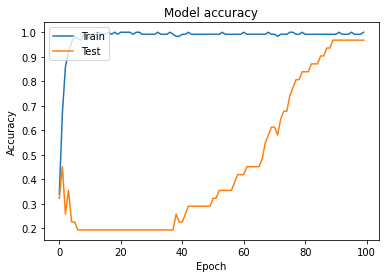

In [0]:
import matplotlib.pyplot as plt

plt.plot(histories[study.best_trial.number].history['accuracy'])
plt.plot(histories[study.best_trial.number].history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

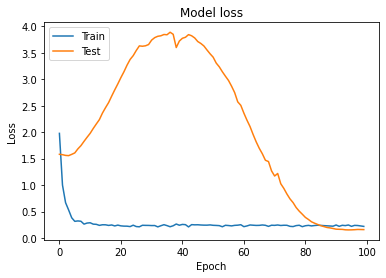

In [0]:
plt.plot(histories[study.best_trial.number].history['loss'])
plt.plot(histories[study.best_trial.number].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')